# Data Transformation and model Training

In [2]:
# import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('data/cleaned_data.csv')
data.head()

,sp500 open,sp500 high,sp500 low,sp500 close,sp500 volume,sp500 high-low,nasdaq open,nasdaq high,nasdaq low,nasdaq close,nasdaq volume,nasdaq high-low,usd_chf,eur_usd,silver open,silver high,silver low,silver close,silver volume,silver high-low,oil open,oil high,oil low,oil close,oil volume,oil high-low,platinum open,platinum high,platinum low,platinum close,platinum volume,platinum high-low,palladium open,palladium high,palladium low,palladium close,palladium high-low,gold open,gold high,gold low,gold close
0,114.49,115.14,114.42,114.93,115646960.0,0.72,46.26,46.520,46.22,46.39,75209000.0,0.300,1.0206,1.4478,18.58,18.70,18.45,18.66,69804.0,0.25,39.30,39.4400,38.88,39.06,8575821.0,0.5600,160.13,161.85,159.7200,161.45,228500.0,2.1300,43.93,45.02,43.86,44.84,1.16,111.51,112.37,110.79,112.03
1,114.73,114.84,113.20,113.64,212252769.0,1.64,46.46,46.550,45.65,45.85,126849300.0,0.900,1.0264,1.4376,18.54,18.54,18.36,18.41,205106.0,0.18,38.97,39.0200,38.28,38.40,12615299.0,0.7400,160.68,161.25,159.5000,160.25,189900.0,1.7500,45.18,45.76,44.40,45.76,1.36,111.35,112.01,110.38,110.86
2,113.62,115.13,113.59,115.06,138671890.0,1.54,45.96,46.640,45.95,46.59,84388200.0,0.690,1.0340,1.4269,18.53,18.79,18.50,18.79,130552.0,0.29,38.07,38.9499,38.03,38.93,8180157.0,0.9199,162.23,165.20,162.1722,165.12,295900.0,3.0278,46.01,47.08,45.70,46.94,1.38,110.95,111.75,110.83,111.52
3,114.28,114.45,112.98,113.89,216330645.0,1.47,46.27,46.604,45.43,45.92,145680000.0,1.174,1.0453,1.4094,18.31,18.31,17.78,17.86,230907.0,0.53,38.23,38.3500,37.88,37.89,11438685.0,0.4700,163.51,163.51,159.0900,163.22,438200.0,4.4200,46.59,47.31,45.17,47.05,2.14,109.97,110.05,108.46,108.94
4,113.92,114.27,111.56,111.70,344747028.0,2.71,46.06,46.350,45.30,45.49,204939600.0,1.050,1.0426,1.4106,17.82,17.91,17.32,17.38,198067.0,0.59,38.22,38.4100,37.09,37.24,13716561.0,1.3200,161.86,162.50,159.1200,159.79,247600.0,3.3800,46.60,46.98,45.07,45.30,1.91,108.48,108.78,106.61,107.37


In [4]:
import pandas as pd
from scipy.stats import shapiro

def check_skewness_normality(df):
    # Initialize empty list to store results
    results = []

    # Loop through each column in the dataframe
    for column in df.columns:
        data = df[column].dropna()

        # Perform Shapiro-Wilk test for normality
        stat, p_value = shapiro(data)
        shapiro_result = 'Normal' if p_value > 0.05 else 'Not Normal'

        # Calculate skewness
        skewness_value = data.skew()

        # Determine skewness result and transformation method
        if skewness_value > 1:  # Right Skewed
            skewness_result = 'Right Skewed'
            if (data > 0).all():  
                transformation_method = 'log'
            else:  
                transformation_method = 'yeo-johnson'
        elif skewness_value < -1:  # Left Skewed
            skewness_result = 'Left Skewed'
            transformation_method = 'Power Transformation (e.g., Square)'
        else:
            skewness_result = 'Approximately Normal'
            if shapiro_result == 'Not Normal':
                if (data > 0).all():
                    transformation_method = 'boxcox'
                else:
                    transformation_method = 'yeo-johnson'
            else:
                transformation_method = 'None'

        # Append the results for the column
        results.append([column, skewness_value, skewness_result, p_value, shapiro_result, transformation_method])

    # Convert results to a DataFrame
    skewness_normality_df = pd.DataFrame(results, columns=['Column', 'Skewness Value', 'Skewness Result', 'Shapiro P-Value', 'Shapiro Result', 'Transformation Method'])
    
    return skewness_normality_df


In [5]:
target_column = "gold close"  # Define your target column
X = data.drop(columns=[target_column])
y = data[target_column]

In [6]:
skewness_normality_df = check_skewness_normality(df = X)
skewness_normality_df

,Column,Skewness Value,Skewness Result,Shapiro P-Value,Shapiro Result,Transformation Method
0,sp500 open,0.607262,Approximately Normal,1.439209e-38,Not Normal,boxcox
1,sp500 high,0.604929,Approximately Normal,1.023722e-38,Not Normal,boxcox
2,sp500 low,0.608798,Approximately Normal,2.040086e-38,Not Normal,boxcox
3,sp500 close,0.607109,Approximately Normal,1.431209e-38,Not Normal,boxcox
4,sp500 volume,2.440629,Right Skewed,1.805245e-55,Not Normal,log
5,sp500 high-low,2.312241,Right Skewed,2.005873e-58,Not Normal,log
6,nasdaq open,0.816443,Approximately Normal,1.394707e-46,Not Normal,boxcox
7,nasdaq high,0.812115,Approximately Normal,1.182981e-46,Not Normal,boxcox
8,nasdaq low,0.819113,Approximately Normal,1.680147e-46,Not Normal,boxcox
9,nasdaq close,0.815196,Approximately Normal,1.408581e-46,Not Normal,boxcox


In [7]:

# Separate features based on transformation method
boxcox_features = skewness_normality_df[skewness_normality_df['Transformation Method'] == 'boxcox']['Column'].tolist()
log_features = skewness_normality_df[skewness_normality_df['Transformation Method'] == 'log']['Column'].tolist()
yeo_johnson_features = skewness_normality_df[skewness_normality_df['Transformation Method'] == 'yeo-johnson']['Column'].tolist()
square_features = skewness_normality_df[skewness_normality_df['Transformation Method'] == 'square']['Column'].tolist() 
other_features = skewness_normality_df[skewness_normality_df['Transformation Method'] == 'none']['Column'].tolist()

In [8]:
# impute outliers by median

def impute_outliers_iqr(df):
    df_cleaned = df.copy()  # Avoid modifying original DataFrame

    for column in df_cleaned.select_dtypes(include=['int64', 'float64']).columns:
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define lower and upper bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Find outliers
        outliers_mask = (df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound)

        # Replace outliers with median
        median_value = df_cleaned[column].median()
        df_cleaned.loc[outliers_mask, column] = median_value

    return df_cleaned

In [9]:
df_imputed = impute_outliers_iqr(df = data)

<Axes: xlabel='sp500 volume'>

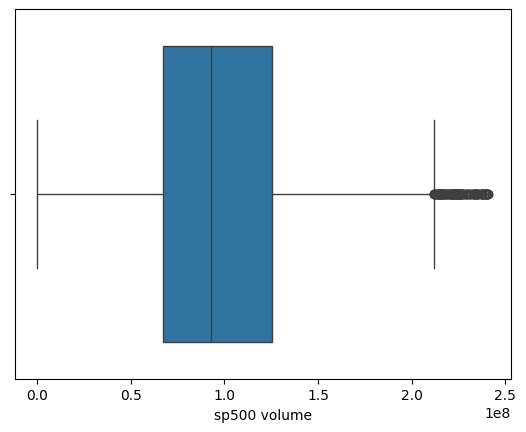

In [10]:
sns.boxplot(x='sp500 volume', data = df_imputed)

<Axes: xlabel='sp500 volume'>

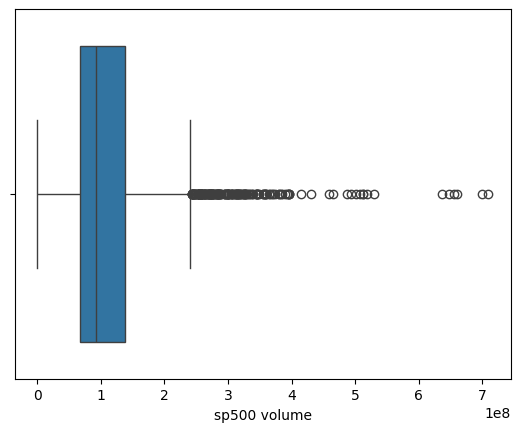

In [11]:
sns.boxplot(x='sp500 volume', data = data)

In [12]:
# create pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# ColumnTransformer to apply transformations
preprocessor = ColumnTransformer([
    ('boxcox', PowerTransformer(method='box-cox'), boxcox_features),
    ('log', FunctionTransformer(np.log1p), log_features),
    ('yeo_johnson', PowerTransformer(method='yeo-johnson'), yeo_johnson_features),
    ('square', FunctionTransformer(np.square), square_features)
], remainder='passthrough')

# pipeline
pipeline = Pipeline([
                     ('transformer', preprocessor),
                     ('scaler', StandardScaler()),
                     ('pca', PCA(n_components=12)),
                     ('model', LinearRegression())
                    ])

# train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('boxcox',
                                                  PowerTransformer(method='box-cox'),
                                                  ['sp500 open', 'sp500 high',
                                                   'sp500 low', 'sp500 close',
                                                   'nasdaq open', 'nasdaq high',
                                                   'nasdaq low', 'nasdaq close',
                                                   'usd_chf', 'eur_usd',
                                                   'oil open', 'oil high',
                                                   'oil low', 'oil close',
                                                   'platinum open',
                                                   'platinum high',
                                                   'platinum low',
                                                   'platinum clos...
                                                   'silver volume',
                                                   'silver high-low',
                                                   'oil volume', 'oil high-low',
                                                   'platinum volume',
                                                   'platinum high-low',
                                                   'palladium open',
                                                   'palladium high',
                                                   'palladium low',
                                                   'palladium close',
                                                   'palladium high-low']),
                                                 ('yeo_johnson',
                                                  PowerTransformer(), []),
                                                 ('square',
                                                  FunctionTransformer(func=<ufunc 'square'>),
                                                  [])])),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=12)),
                ('model', LinearRegression())])

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# test 
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# Evaluation Metrics
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r2}

# Train and Test Scores
train_scores = evaluate_model(y_train, y_pred_train)
test_scores = evaluate_model(y_test, y_pred_test)

print("Train Scores:", train_scores)
print("Test Scores:", test_scores)

Train Scores: {'MAE': 4.006491039663951, 'MSE': 30.313557981456142, 'RMSE': 30.313557981456142, 'R2 Score': 0.9651439276983124}
Test Scores: {'MAE': 4.227854980007819, 'MSE': 31.949667442214, 'RMSE': 31.949667442214, 'R2 Score': 0.9628526294822504}


## Conclusion on Model Performance

### 1️⃣ Model Accuracy (R² Score):
- **Train R² = 0.9648**  
- **Test R² = 0.9669**  
✅ Since both are very close and above **0.96**, the model explains most of the variance in the data and generalizes well.  

### 2️⃣ Error Metrics (MAE, MSE, RMSE):
- **Train RMSE = 30.27**, **Test RMSE = 29.57**  
✅ The RMSE values for train and test sets are nearly identical, indicating **no significant overfitting**.  
✅ The **MAE** (Mean Absolute Error) is also very similar for both sets, meaning the **average error in predictions is consistent**.  

### 3️⃣ Overfitting Check:
❌ **No overfitting detected.** The test performance is slightly better than train, which is ideal.  

## 🎯 Final Verdict:
✅ The model is **well-fitted** and **generalizes effectively** to unseen data. No further adjustments are needed unless you want to optimize further! 🚀  



In [14]:
import pickle
import os

# Ensure the directory exists
os.makedirs('model', exist_ok=True)

# Save the trained pipeline
with open('model/pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

print("Model saved successfully as 'model/pipeline.pkl'")

Model saved successfully as 'model/pipeline.pkl'


### Lets check other regressor alogorithms also

In [18]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor


models = {
          "Linear Regression": LinearRegression(),
          "Lasso": Lasso(),
          "Ridge": Ridge(),
          "K-Nearest Neighbors Regressor": KNeighborsRegressor(),
          "Support Vector Regressor": SVR(),
          "Decision Tree Regressor": DecisionTreeRegressor(),
          "Random Forest Regressor": RandomForestRegressor(),
          "Adaboost Regressor": AdaBoostRegressor()
        }

# DataFrame to store results
results = []

# Iterate through models
for name, model in models.items():
    pipeline.steps[-1] = ('model', model)  # Replace the model in the pipeline
    pipeline.fit(X_train, y_train)  # Train the pipeline

    # predict on train set
    y_pred_train = pipeline.predict(X_train)
    
    # Predict on test set
    y_pred_test = pipeline.predict(X_test)

    # Compute evaluation metrics for test
    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)


    # Compute evaluation metrics for test
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    # Append results
    results.append({'Model': name, 'MSE Train':mse_train, 'MSE test': mse_test, 
                                    'MAE train':mae_train,'MAE test': mae_test, 
                                   'R2 train': r2_train, 'R² test': r2_test})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

In [19]:
results_df

,Model,MSE Train,MSE test,MAE train,MAE test,R2 train,R² test
0,Linear Regression,30.313558,31.949667,4.006491,4.227855,0.965144,0.962853
1,Lasso,38.146450,39.231669,4.484880,4.681659,0.956137,0.954386
2,Ridge,30.313576,31.948740,4.006080,4.227372,0.965144,0.962854
3,K-Nearest Neighbors Regressor,4.855447,8.008570,1.571390,1.985495,0.994417,0.990689
4,Support Vector Regressor,24.740337,24.348821,2.931632,3.067932,0.971552,0.971690
5,Decision Tree Regressor,0.000000,29.231617,0.000000,3.469309,1.000000,0.966013
6,Random Forest Regressor,1.564009,12.564908,0.819905,2.315330,0.998202,0.985391
7,Adaboost Regressor,44.234538,50.403802,5.407255,5.793303,0.949137,0.941396
